## Analysis on Air Quality Dataset

This notebook contains the analysis performed on the daily AQI dataset published by EPA. The following sections go through the data science lifecycle and raise intersting discoveries. Before we dive into detail, we first import the necessary libraries.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# import sys
# !{sys.executable} -m pip install reverse_geocoder

import numpy as np
import pandas as pd
import seaborn as sns
import reverse_geocoder as rg
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

## Data Sampling and Collection

In this section, we illustrate the process to collect the data and discuss interesting findings.

__Q: How were the data collected?__

The dataset on daily Air Quality Index (AQI) for year 2020 is collected from the Environmental Protection Agency (EPA)'s Air Data database, which contains daily AQI measurements over core based statistical areas (CBSA) [1] in US. The Air Data database updates every Sunday night, so the expected lag between new data and the snapshot on database does not extend over a week [2]. The EPA also has proper method to regularly sync up with the sources (almost daily), and the EPA established May 1st as the date for which the previous year's data should be complete and accurate [2]. Given that the dataset we use is from 2018-2020, we believe there will not be syncing issues or dataset update issues.

The dataset we download contains the daily AQI measurements over CBSAs in the US region for a given year. So, each row in the dataset represents a given CBSA's air quality on a given date in 2020. Note that, according to [2], if a region has more than one sites recording, the resulting AQI is taken as the maximum among all sites of that region, on that date.

To sum up, the dataset is collected from Air Data database from EPA, which collects these AQIs from measurement stations in CBSAs within the US on a daily basis.

__Q: Was there any potential bias introduced in the sampling process?__

According to [2], the air Data database's information is collected from designated measurement stations. So, there may exist selection bias, because stations that do not work with the EPA will not submit their data to the Air Data database. Also, note that the AQI measurement for a given CBSA region is taken as the maximum among all measurement sites in that region. While this seems reasonable when we are discussing air quality (after all, we care about the extent of the badness), but in certain cases we may also want to investigate the distribution of air quality in that region from multiple sites. This way, it may yield new insights on that region. Maybe a sub-region in that area has a fireworks holiday, peaking the AQI and thus causing the entire region to be "labeled" as that index. So, this "max sampling" could also induce a certain level of selection bias. However, for the purpose of our application (using several metrics to predict the air quality over a region with respect to time), I think using the max sampling is still fine, because we are not going to narrow down to each sub-region anyways.

## Data Cleaning

We inspect the dataset and perform data cleaning. Then, we discuss the findings. We start by loading the dataset, which contains the AQI measured at all CBSA regions in California state in 2020. Note that we could also gather a similar dataset for different state using the same data cleaning process shown below.

In [2]:
daily_aqi = pd.read_csv("../data/ad_viz_plotval_data_aqi_2020.csv")
daily_aqi.head()

,Date,Source,Site ID,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/01/2020,AQS,60010007,3,8.6,ug/m3 LC,36,Livermore,1,100.0,88101,PM2.5 - Local Conditions,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217
1,01/02/2020,AQS,60010007,3,4.5,ug/m3 LC,19,Livermore,1,100.0,88101,PM2.5 - Local Conditions,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217
2,01/03/2020,AQS,60010007,3,14.2,ug/m3 LC,55,Livermore,1,100.0,88101,PM2.5 - Local Conditions,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217
3,01/04/2020,AQS,60010007,3,10.9,ug/m3 LC,45,Livermore,1,100.0,88101,PM2.5 - Local Conditions,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217
4,01/05/2020,AQS,60010007,3,7.8,ug/m3 LC,33,Livermore,1,100.0,88101,PM2.5 - Local Conditions,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217


__Q: What type of data are you exploring?__

At this point, we can say that we are exploring numerical data in this dataset. The below contains a description for each column in the dataframe. We will drop several of them that are not related the project's goal.

- "Date" encodes time-series information on when the AQI info is reported. We may convert this column to datetime objects.
- "Source" is a label that indicates the source of this report. The entire dataframe is from the same source (AQS).
- "Site ID" is a qualitative nominal variable that uniquely identifies the measurement site.
- "POC" is the parameter occurrence code, which is used to uniquely identify a monitor if there is more than one device measuring the same pollutant at the same site.
- "Daily Mean PM2.5 Concentration" is a quantitative continously variable that records the daily mean PM2.5 Concentration.
- "UNITS" column indicates the measurement unit for the mean PM2.5 Concentration.
- "DAILY_AQI_VALUE" indicates the air quality index on that date in that location.
- "Site Name" is the name of the site that the measurement was taken.
- "DAILY_OBS_COUNT" records the number of observations taken during that day.
- "PERCENT_COMPLETE" indicates how complete is the record for that date.
- "AQS_PARAMETER_CODE" indicates the AQS code corresponding to the parameter measured by the monitor.
- "AQS_PARAMETER_DESC" contains a description about the AQS measurement.
- "CBSA_CODE" is uniquely assigned to each CBSA region.
- "CBSA_NAME" is the official name for that CBSA region.
- "STATE_CODE" is uniquely assigned to each state.
- "STATE" is the official name for that state.
- "COUNTY" indicates which county was the measurement taken place.
- "SITE_LATITUDE" indicates the measurement site's geographical latitude.
- "SITE_LONGITUDE" indicates the measurement site's geographical longitude.

Given that we wish to use temperature, greenhouse emissions, and other factors to predict AQI, we can see that columns "SOURCE, POC, SITE_NAME, DAILY_OBS_COUNT, AQS_PARAMETER_DESC, COUNTY, SITE_LATITUDE, SITE_LONGITUDE" are all non-relevant. We will drop them.

In [3]:
daily_aqi = daily_aqi[["Date", "Site ID", "Daily Mean PM2.5 Concentration", "UNITS", 
                       "DAILY_AQI_VALUE", "PERCENT_COMPLETE", "AQS_PARAMETER_CODE", 
                       "CBSA_CODE", "CBSA_NAME", "STATE_CODE", "STATE"]]
daily_aqi.head()

,Date,Site ID,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,PERCENT_COMPLETE,AQS_PARAMETER_CODE,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE
0,01/01/2020,60010007,8.6,ug/m3 LC,36,100.0,88101,41860.0,"San Francisco-Oakland-Hayward, CA",6,California
1,01/02/2020,60010007,4.5,ug/m3 LC,19,100.0,88101,41860.0,"San Francisco-Oakland-Hayward, CA",6,California
2,01/03/2020,60010007,14.2,ug/m3 LC,55,100.0,88101,41860.0,"San Francisco-Oakland-Hayward, CA",6,California
3,01/04/2020,60010007,10.9,ug/m3 LC,45,100.0,88101,41860.0,"San Francisco-Oakland-Hayward, CA",6,California
4,01/05/2020,60010007,7.8,ug/m3 LC,33,100.0,88101,41860.0,"San Francisco-Oakland-Hayward, CA",6,California


Now, we explore a few things to further clean the data. First, do we have the same measurement unit across the entire dataframe? If so, we can save the unit ug/m^3 LC and drop the UNIT column.

In [4]:
assert len(daily_aqi["UNITS"].unique()) == 1  # so we can drop the UNIT Column

Second, are all the measurements complete? If so, we can drop the PERCENT_COMPLETE column.

In [5]:
assert len(daily_aqi["PERCENT_COMPLETE"].unique()) == 1  # so we can drop the PCT_COMPELTE Column

Third, are all measurements measuring the same AQS standard?

In [6]:
daily_aqi["AQS_PARAMETER_CODE"].value_counts()

88101    39013
88502    15183
Name: AQS_PARAMETER_CODE, dtype: int64

Turns out for our application, there is no difference between 88101 and 88502. According to [2], "Reports and visualization tools providing AQI data use both 88101 and 88502 (ACCEPTABLE PM2.5 AQI & SPECIATION MASS)". 

In [7]:
daily_aqi = daily_aqi.drop(columns=[
    "UNITS",
    "PERCENT_COMPLETE",
    "AQS_PARAMETER_CODE"
])

daily_aqi.head()

daily_aqi = daily_aqi.rename(columns={"Daily Mean PM2.5 Concentration": "mean pm2.5 in um/m^3 LC"})

Now we see the preprocessed dataframe.

In [8]:
daily_aqi.head()

,Date,Site ID,mean pm2.5 in um/m^3 LC,DAILY_AQI_VALUE,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE
0,01/01/2020,60010007,8.6,36,41860.0,"San Francisco-Oakland-Hayward, CA",6,California
1,01/02/2020,60010007,4.5,19,41860.0,"San Francisco-Oakland-Hayward, CA",6,California
2,01/03/2020,60010007,14.2,55,41860.0,"San Francisco-Oakland-Hayward, CA",6,California
3,01/04/2020,60010007,10.9,45,41860.0,"San Francisco-Oakland-Hayward, CA",6,California
4,01/05/2020,60010007,7.8,33,41860.0,"San Francisco-Oakland-Hayward, CA",6,California


__Q: What is the granularity of the data?__

Each row represents an summary of the air quality measurement at a given station in a given CBSA in California between in 2020. I call it a summary because in certain cases, the station conducts several measurements on a day. But, it generates one record containing the mean pm2.5 across all measurements for that day and the max of the AQI value for that date.

We then convert the data to the desired form and check for outliers in each column.

In [9]:
# Date captures the date of the measurement
daily_aqi["Datetime"] = pd.to_datetime(daily_aqi["Date"], format="%m/%d/%Y")
# the date range is valid, but we miss values after Oct-22, 2020. The 296 unique values suggest we have good
# coverage within the month from Jan to Oct.
print("Date in datetime format:")
print(daily_aqi["Datetime"].describe())
print()

# mean pm2.5 indicates the amount of harmful particles. The more the worse the air quality
print("PM2.5 Mean:")
print(daily_aqi["mean pm2.5 in um/m^3 LC"].describe())
print()

# daily AQI is another way of telling the story indicated by mean pm2.5
print("AQI:")
print(daily_aqi["DAILY_AQI_VALUE"].describe())
print()

Date in datetime format:
count                   54196
unique                    366
top       2020-01-04 00:00:00
freq                      209
first     2020-01-01 00:00:00
last      2020-12-31 00:00:00
Name: Datetime, dtype: object

PM2.5 Mean:
count    54196.000000
mean        12.538126
std         19.916190
min         -3.000000
25%          4.700000
50%          8.100000
75%         13.500000
max        824.100000
Name: mean pm2.5 in um/m^3 LC, dtype: float64

AQI:
count    54196.000000
mean        41.486198
std         33.924635
min          0.000000
25%         20.000000
50%         34.000000
75%         54.000000
max        714.000000
Name: DAILY_AQI_VALUE, dtype: float64



We ignore analysis on SiteID, CBSA_Code, State_code and State because these are not numerical variables of interest. Additionally, for the final mode, we aim to build a model on a particular area, so we don't necessarily need to see the entire list of locations, if that makes sense.

Now, based on above analysis, there are no outliers in this dataset. Here, we use external sources to reasonably gauge if the values in a column is normal. For example, we checked the AQI index ranges [3], and 714 is labeled as hazardous, and this could be attributed to the California wildfire in the previous year. Additionally, we spot some negative values in the PM2.5 mean column. According to [4], this is fine, as stated by EPA (all negative numbers reported is greater than -10, so the data is coherent and conform to standard. So, this dataset does not contain outliers.

Now we check if the dataset has missing values.

In [10]:
print(daily_aqi.isnull().sum())

Date                          0
Site ID                       0
mean pm2.5 in um/m^3 LC       0
DAILY_AQI_VALUE               0
CBSA_CODE                  4496
CBSA_NAME                  4496
STATE_CODE                    0
STATE                         0
Datetime                      0
dtype: int64


In [11]:
# we inspect these rows
filtered_df = daily_aqi[daily_aqi["CBSA_CODE"].isnull()]
filtered_df

,Date,Site ID,mean pm2.5 in um/m^3 LC,DAILY_AQI_VALUE,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,Datetime
3221,01/01/2020,60090001,17.8,63,NaN,NaN,6,California,2020-01-01
3222,01/02/2020,60090001,14.2,55,NaN,NaN,6,California,2020-01-02
3223,01/03/2020,60090001,13.2,53,NaN,NaN,6,California,2020-01-03
3224,01/04/2020,60090001,12.0,50,NaN,NaN,6,California,2020-01-04
3225,01/05/2020,60090001,14.5,56,NaN,NaN,6,California,2020-01-05
...,...,...,...,...,...,...,...,...,...
50744,04/09/2020,61059000,3.8,16,NaN,NaN,6,California,2020-04-09
50745,04/12/2020,61059000,1.7,7,NaN,NaN,6,California,2020-04-12
50746,04/24/2020,61059000,1.2,5,NaN,NaN,6,California,2020-04-24
50747,04/27/2020,61059000,0.7,3,NaN,NaN,6,California,2020-04-27


We can see that these rows are bad records, as they don't indicate which CBSA is the reports for. So, we drop those rows.

In [12]:
daily_aqi = daily_aqi[~daily_aqi.index.isin(filtered_df.index)]
daily_aqi = daily_aqi.drop(columns=['Date'])
daily_aqi.head()

,Site ID,mean pm2.5 in um/m^3 LC,DAILY_AQI_VALUE,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,Datetime
0,60010007,8.6,36,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,2020-01-01
1,60010007,4.5,19,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,2020-01-02
2,60010007,14.2,55,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,2020-01-03
3,60010007,10.9,45,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,2020-01-04
4,60010007,7.8,33,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,2020-01-05


__Q: Are there missing value or invalid entries in the dataset?__

By the above analysis, this dataset contains 4496 rows that do not have CBSA_CODE and CBSA_NAME. Because the loss of these values will not aid in our analysis (we cannot attribute the row to a given CBSA aribitrialy), we drop them. Other than this, the dataset does not contain missing values or invalid entries in other columns.

We get a better sense of the distribution of data through plotting.

In [13]:
# define a plotting function to visualize distribution
def visualize_uni_distribution(df, name, ax, trans=None, prs=None):
    if trans is None:
        sns.distplot(df[name], ax=ax)
    elif trans == "log":
        if prs == "abs":
            eps = 1e-10
            sns.distplot(np.abs(np.log10(df[name] + eps)), ax=ax)

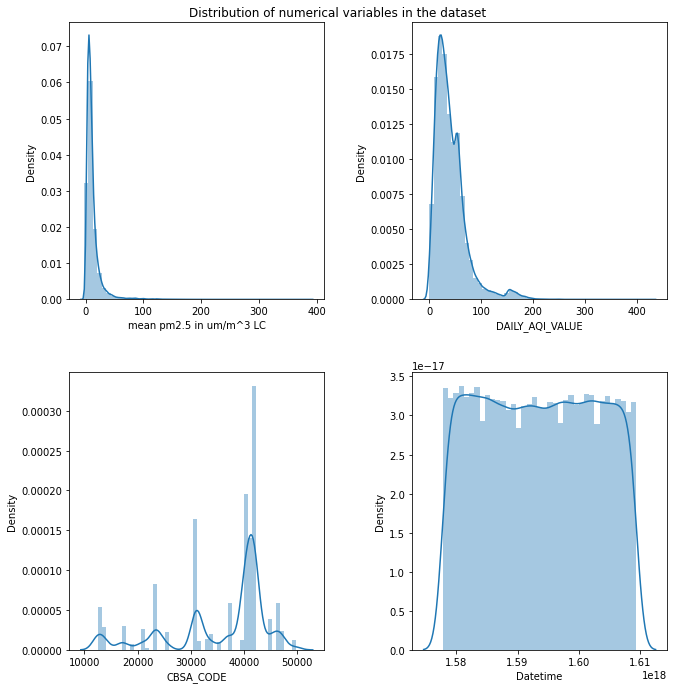

In [14]:
# we see the distribution for each variable (except SiteID, )
fig, axs = plt.subplots(2, 2, figsize=(10,10))
i, j = 0, 0

for var in daily_aqi.columns.to_list():
    if var in ["Site ID", "CBSA_NAME", "STATE_CODE", "STATE"]:
        continue
    visualize_uni_distribution(daily_aqi, var, axs[i, j])
    if j == 1:
        i += 1
        j = 0
    else:
        j += 1

fig.tight_layout(pad=3.0)
fig.suptitle("Distribution of numerical variables in the dataset");

__Q: What does the distribution of the data looks like?__

__Mean PM2.5:__
This data is unimodal and is heavily right skewed. The majority of mean PM2.5 values exist between 0-50 um/m^3. 

__Daily AQI Value:__
This data is roughly unimodal, and is right skewed. The majority of daily aqi values exist between 0-100. That means, fortunately, most of the time in California, we have good or moderate level of air quality, according to [3].

__CBSA_CODE:__
This data is multinomial. Basically, the graphs show how many major CBSA regions do we have in california. This gives us a sense of how the reports are distributed geographically speaking. 

__Datetime:__
This data is pretty uniform, with 4 troughs between 2020-01-01 and 2020-12-31. The visulization suggests that we have good coverage of data across Jan 2020 to Oct 2020. We may further inspect the date of the four troughs. Could these four days be the days where the database gets maintainance?

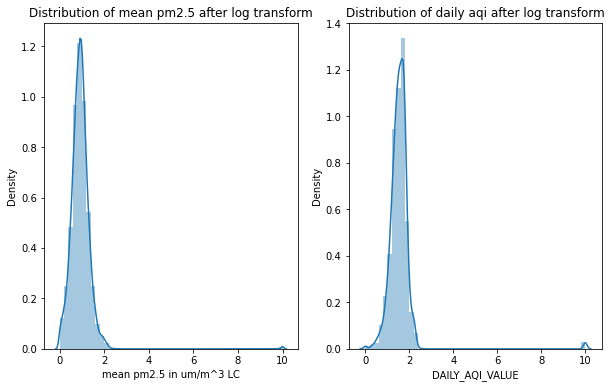

In [15]:
fig_1, ax = plt.subplots(1, 2, figsize=(10,6))
visualize_uni_distribution(daily_aqi, "mean pm2.5 in um/m^3 LC", ax[0], trans="log", prs="abs")
ax[0].set_title("Distribution of mean pm2.5 after log transform");

visualize_uni_distribution(daily_aqi, "DAILY_AQI_VALUE", ax[1], trans="log", prs="abs")
ax[1].set_title("Distribution of daily aqi after log transform");

From above visulizations and analysis, we can see that we have uniformly distributed data from each day between 2020-01-01 to 2020-12-31.

Then, if we look at mean pm2.5s, we can see that the data is heavily right skewed. The log transformation then indicates that we have a great amount of data in the  0  and  100 (in the original axis). This visulization suggests that we tend to have good to moderate level of air pollution. We are very unlikely to see hazardous level of pm 2.5 in california, in 2020.

Then, if we look at daily aqi, which is another way of telling the mean pm2.5, we can see that the data is again right skewed. The log transformation then indicates that we have a great amount of data in the  0  and  100 (in the original axis). This visulization suggests that we tend to have good to moderate level of air pollution. We are very unlikely to see hazardous level of air quality in california, in 2020. Though, given that in 2020, we have seen the california wildfire, as indicated by the small peak near 10 in the right log transformed graph.

The visulization on CBSA_CODE may later be used to determine what are the popular places for these stations, i.e., what are the geographical locations that have a lot of such stations.

## Exploratory Data Analysis

In this section, we explore the relationship between variables and getting to know more about the data. Note that, in the end, we plan to combine several dataset together. Then, we will gather another analysis notebook to explore the correlation between the features and the column to predict. For now, we are just trying to explore some basic elements of this dataset. Please be assured that more will follow in the final notebook :)

In [16]:
# we make it more fine grained
daily_aqi["year"] = daily_aqi["Datetime"].dt.year
daily_aqi["month"] = daily_aqi["Datetime"].dt.month
daily_aqi["week"] = daily_aqi["Datetime"].dt.week
daily_aqi["day"] = daily_aqi["Datetime"].dt.day

daily_aqi.head()

,Site ID,mean pm2.5 in um/m^3 LC,DAILY_AQI_VALUE,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,Datetime,year,month,week,day
0,60010007,8.6,36,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,2020-01-01,2020,1,1,1
1,60010007,4.5,19,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,2020-01-02,2020,1,1,2
2,60010007,14.2,55,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,2020-01-03,2020,1,1,3
3,60010007,10.9,45,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,2020-01-04,2020,1,1,4
4,60010007,7.8,33,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,2020-01-05,2020,1,1,5


__Exploration 1: Is there a relationship between CBSA location and AQI value?__ Intuitively, we want to explore if a certain CBSA in California has on average higher AQI as compared with other regions. For example, we may want to ask if San Francisco has lower aqi over the months as Sacramento? Or we may want to ask if the city has higher AQI than the suberbs?

To actually see the relationship, we need to make several generalizations.
1. We want to generalize the data and group by the CBSA regions to see the trend, because we aim to trace relationship between a geographical region and AQI. When calculating the desired AQI, we take the average of that date across all stations in that location.

2. After we group by the CBSA and extract the AQI information with respect to the 2020-01-01 to 2020-12-31 range (in terms of monthly average), we observe some rows have missing values. Through inspection, the max number of missing value a row has is 2, so we just fill it with the np.mean of that row.

3. We want to randomly sample a subset of the rows after the first step, to avoid overplotting. The dataframe after we group by CBSA, cleaned for nans, still have 55 values. This means that we cannot plot all of their AQI trend on one graph. Here, we sample 50% to avoid overplotting while seeing the trend.

In [17]:
# construct a pivot_table for AQI
location_to_aqi = daily_aqi.pivot_table(index="CBSA_NAME", columns="month", values="DAILY_AQI_VALUE", aggfunc=np.mean)
location_to_aqi.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
CBSA_NAME,,,,,,,,,,,,
"Bakersfield, CA",36.005587,35.159509,19.104651,25.982036,27.634146,34.247059,42.150289,68.983146,87.149254,71.579882,52.532934,47.101796
"Bishop, CA",11.487179,16.305556,10.855263,13.750000,18.820896,24.418919,26.366667,54.790909,116.438095,85.390476,30.390476,30.349057
"Chico, CA",36.448980,34.400000,17.093023,18.188889,15.955056,19.544444,31.318681,75.715909,108.883117,62.185185,39.500000,42.141304
"Clearlake, CA",11.800000,15.600000,16.400000,14.000000,12.200000,14.800000,25.400000,66.333333,81.600000,38.000000,19.000000,19.800000
"Crescent City, CA",22.843750,32.702703,22.657895,25.714286,NaN,NaN,20.600000,31.967742,60.555556,49.774194,38.433333,38.586207


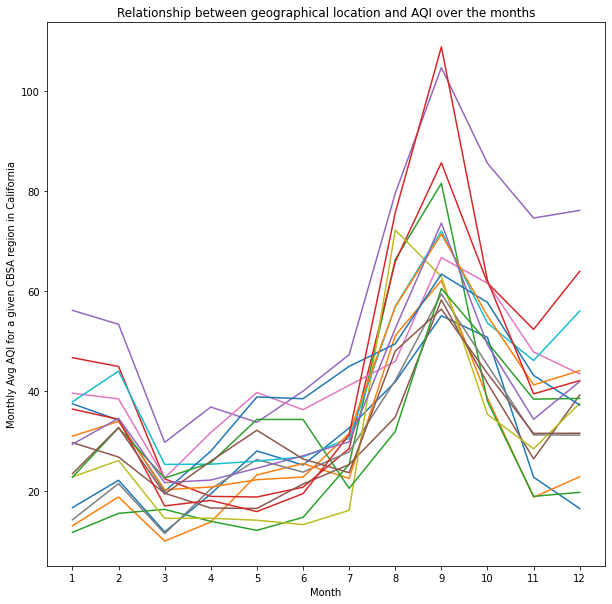

In [18]:
# print(location_to_aqi.isnull().sum())
# We can see some locations have 1 or 2 null values after this process. 
# We fill it with the mean of that row

flt = pd.DataFrame(location_to_aqi.to_records())

# to avoid data clustering, we gather 50% states to plot
flt_sampled = flt.sample(frac=0.5, replace=False, random_state=1)

# filter
flt_sampled = flt_sampled.set_index("CBSA_NAME")

# we apply np.mean row-wise
flt_sampled = flt_sampled.apply(lambda row: row.fillna(row.mean()), axis=1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
for row in flt_sampled.iterrows():
    sns.lineplot(flt_sampled.columns.to_list(), row[1], ax=ax)

ax.set_xlabel("Month");
ax.set_ylabel("Monthly Avg AQI for a given CBSA region in California");
ax.set_title("Relationship between geographical location and AQI over the months");

From the above curve, we see that there is indeed a trend between geographical location and the AQI variation over the seasons, this is evident because all lines follow a similar strcture while being shifted veritically. This graphs tell us many things, including:

1. The CBSA regions in the California area all follow a genera trend for the AQI as month progresses. This has to do with many reasons: temperature, precipitation (as we have analyzed in another notebook), different level of human activities over the months, and seasons.

2. The vertical shifts from a curve to the other tells us that major cities tend to have higher AQI over the months than suberbs.

3. This pattern indicates that we can use features such as temperature, precipitation, month, traffic, and greenhouse emissions to predict AQI. Why? From the plot, we can see the effect of seasons on the AQI. Note that during the transition from summer to fall, we see the peak in AQI, probably due to people starts using ACs in the CA region. There are many more factors, the AC is just an example.


__Exploration 2: What months tend to produce higher AQIs? Does the discovery align with scientific explanantion? If we inspect the relationship in terms of weeks, would we find a oscillation pattern?__

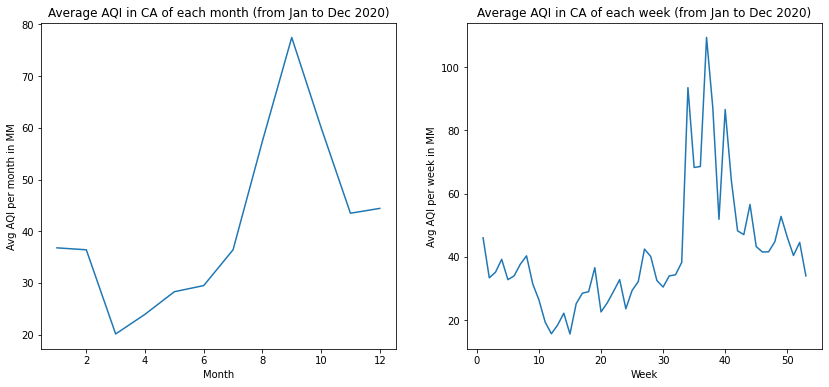

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))

month_aqi_avg = daily_aqi.groupby(["month"])["DAILY_AQI_VALUE"].agg(np.mean)
axs[0].plot(month_aqi_avg);
axs[0].set_title("Average AQI in CA of each month (from Jan to Dec 2020)");
axs[0].set_xlabel("Month");
axs[0].set_ylabel("Avg AQI per month in MM");

week_aqi_avg = daily_aqi.groupby(["week"])["DAILY_AQI_VALUE"].agg(np.mean)
axs[1].plot(week_aqi_avg);
axs[1].set_title("Average AQI in CA of each week (from Jan to Dec 2020)");
axs[1].set_xlabel("Week");
axs[1].set_ylabel("Avg AQI per week in MM");

Indeed, we validated the trend we see in exploration 1, as the average per month looks closely like the majority of the AQI curves in exploration 1. This suggests that all cities in CA's AQI has a trend, and this trend has to do with temperature, precipitation and other reasons. Now, if we pay more attention to the plot on the left, we see that the air quality gets better in spring, and then starts to decrease (higher AQI) in summer, peaking in September, and starts decreasing again. This aligns with our expectation, because we know one of the major source that contributes to air quality is the amount of greenhouse emission. During the summer, especially in CA, the hot weather causes people to turn on their ACs, and that produce greenhouse gas (CO2). So, we see this peak. Then, in winter, people tend to use ACs less, and so the curve starts to decrease. This is one of the factor, but not all of the factors. So, we can conclude that August and September tend to be the months that have the highest AQI (highest level of air pollution in cities in CA). We can then use this piece of information in modeling.

From the plot to the right, we now see a zig-zag shaped oscillation of the curve that sorts of mimic the trend of the curve to the left if we "smooth" out the zig-zag part. This is again expected. By nature, we know many phenomons oscillate with respect to time, and this is true for air quality as well. This gives us an idea of the level of granularity to be used for the data to be fed into our model, which predicts the air quality.

__Exploration 3: Can we confirm a positive relationship between mean pm2.5 measurements and AQI?__

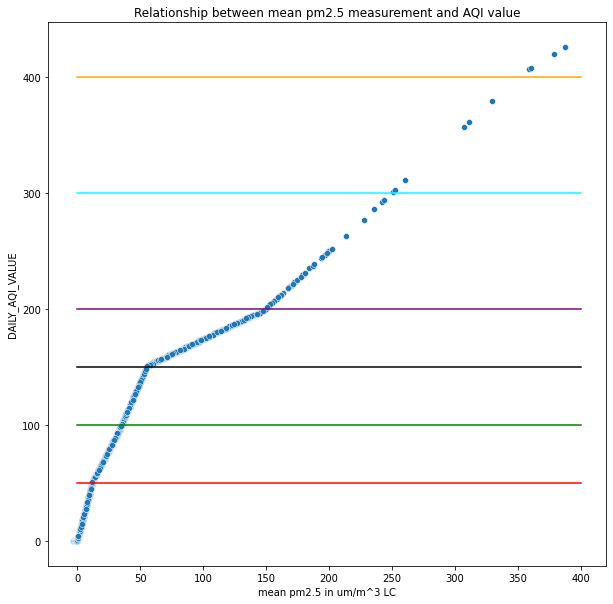

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.scatterplot(data=daily_aqi, 
                x="mean pm2.5 in um/m^3 LC", 
                y="DAILY_AQI_VALUE", 
                ax=ax);
ax.set_title("Relationship between mean pm2.5 measurement and AQI value");

X_plot = np.linspace(0, 400)
Y_50 = 0 * X_plot + 50
plt.plot(X_plot, Y_50, color='r');
Y_100 = 0 * X_plot + 100
plt.plot(X_plot, Y_100, color='g');
Y_150 = 0 * X_plot + 150
plt.plot(X_plot, Y_150, color='black');
Y_200 = 0 * X_plot + 200
plt.plot(X_plot, Y_200, color='purple');
Y_300 = 0 * X_plot + 300
plt.plot(X_plot, Y_300, color='cyan');
Y_400 = 0 * X_plot + 400
plt.plot(X_plot, Y_400, color='orange');

From the above scatter plot, we can see that there is a direct relationship between mean pm 2.5 measurements and AQI. We know this is true because the AQI is determined using a "scoring bin" on the mean pm 2.5 measurements, according to [3]. Here, we just want to verify this, so that we know our dataset is reliable. The above scatter plot indeed demonstrates this relationship. From the scatter plot, we have segemented the AQI value into AQI categories based on [3], and we can clearly see the segmented piecewise linear function that overall generates the graph (for each scoring bin, there is a linear function that maps a pm2.5 value into an AQI value).

For example, according to [3], an AQI index value between 0-50 is considered "GOOD air quality", and the corresponding pm2.5 breakpoints is set to be 0.0-15.0. If you look below the red line, which is the range for AQI to be 0-50, the corresponding x (pm2.5) indeed ranges from 0 to 15.0, roughly speaking. So, we are very happy to verify this fact, by looking the scatter plot above on a real dataset. This discovery allows us to use AQI value or pm 2.5 value along with great confidence, because we know the two has a piece wise linear relationship, so we can map one value to the other as needed.

__Q: Is there any correlation between the variables you are interested in exploring?__

From the above section of analysis, we can see that:

- There is a relationship between geographical location and the average AQI over the months. Specifically, urban cities tend to have higher AQI than suberbs.
- There is a relationship between the month and the average AQI for that month. This is due to how season transitions and the different level of human activities associated with each month.
- There is a clear piece-wise linear relationship between mean pm2.5 and AQI. This serves to illustrate the credibility of the dataset, given we know how mean pm2.5 is used to compute the AQI, we can validate this process and assure the reader that the data is coherent.

From the above discoveries, we could summarize and say that, by collecting the month, mean pm2.5, and geographical locations where the measurement is conducted, we can try building a model to predict the AQI, as both geographical location and month have relationships with AQI. Of course, this model will be more accurate after we incorporate other features such as air pressure, wind, traffic, and greenhouse emission into account. We explore that in separate notebooks.

__Q: How would you cleanly and accurately visualize the relationship among variables?__

This question is answered as we walk through the above three explorations. Basically, several techniques are used to cleanly and accurately visualize the relationship.

Given that we care about the average AQI across the months / weeks, we use averaging to allow the data to generalize and be more smooth. Then, to observe clean and clear trend, we use:

- proper data cleaning routine to remove outliers and fill in missing values through inference
- random sampling to avoid overplotting
- plot the average over the months instead of all data
- proper selction of graphing method and use proper color, and display size
- overlay useful lines on top of plots to indicate piece-wise linear relationship
- use of subplots to compare plots of different granularity on a certain topic

## Data Extraction

## Reference

[1] https://aqs.epa.gov/aqsweb/documents/codetables/cbsas.html

[2] https://www.epa.gov/outdoor-air-quality-data/air-data-frequent-questions

[3] https://aqicn.org/faq/2013-09-09/revised-pm25-aqi-breakpoints/

[4] https://www.epa.gov/sites/production/files/2016-10/documents/pm2.5_continuous_monitoring.pdf